# Yelp API Webscraping

In [332]:
import pandas as pd 
import numpy as np
import json
import requests
import time, datetime
import math

import matplotlib.pyplot as plt
import matplotlib.path as mplpath    # for gathering coordinates inside LA

# Compiled Code
- Don't forget to comment so we can understand!

## known issues:
- function populates dataframe with NaN rows
- do we want business name?
- businesses have multiple categories and function only picks up one at a time
    - currently the 'alias' portion picks up the alias of the business (name), not the category alias

In [64]:
# NOTHING IN THIS CELL NEEDS TO GET CHANGED 
# IF YOU HAVE YOUR API KEY IN 'creds.json' IN ./Assets

# format your json file as a dictionary containing api key with DOUBLE QUOTES
# {"api": "your_super_long_api_key"}
CREDS_FILE = open('../Assets/creds.json')

# load credentials into variable
YELP_CREDENTIALS = json.loads(CREDS_FILE.read())
API_KEY = YELP_CREDENTIALS['api']
HEADERS = {'Authorization': 'Bearer %s' % API_KEY}

# this is the url we use to make broad business searches
# https://www.yelp.com/developers/documentation/v3/business_search

URL = 'https://api.yelp.com/v3/businesses/search'

In [4]:
def get_businesses(location, save):
    
    businesses_object = []
    for offset in range(0, 1000, 50):
        params = {
            'limit': 50, 
            'location': location.replace(' ', '+'),
            'radius': 3200,
            'offset': offset
        }
        response = requests.get(URL, headers=HEADERS, params=params)
        if response.status_code == 200:
            businesses_object += response.json()['businesses']
        elif response.status_code == 400:
            print('400 Bad Request')
            break


    # empty list container containing dictionaries representing each unique business
    businesses = []
    
    # looking at each business which is passed into our function
    for i, business in enumerate(list(businesses_object)):
        
        # each dictionary will contain all of the desired information from each business
        business_dict = {}

        if 'price' in businesses_object[i].keys():
            business_dict['id']           = business['id']
            business_dict['latitude']     = business['coordinates']['latitude']
            business_dict['longitude']    = business['coordinates']['longitude']
            business_dict['price']        = business['price']
            business_dict['review_count'] = business['review_count']
            business_dict['rating']       = business['rating']
            business_dict['zip_code']     = business['location']['zip_code']
            business_dict['city']         = business['location']['city']
            business_dict['alias']        = business['alias']
           
        num_categories = len(businesses_object[i]['categories'])
        
        category_list = []
        
        for num in range(num_categories):
            category = businesses_object[i]['categories'][num]['alias']
            category_list.append(category)
            business_dict['category']     = category_list

        # populate the business list with each business dictionary
        businesses.append(business_dict)

        # just a little sanity check to see how far along our function is going
        if (i+1) % 100 == 0:
            print(f'{i+1} out of {len(businesses_object)}')
    
    businesses = pd.DataFrame(businesses)
    
    # Saves the business dataframe to a csv file with current time
    if save:
        businesses.to_csv(businesses_path,index=False)
        now = datetime.datetime.now()
        businesses_path = "../data/" + location +"_businesses" + now.strftime("%Y-%m-%d_%H_%M") + ".csv"

    return businesses

In [19]:
zips = [90001,
90002,
90003,
90004,
90005,
90006,
90007,
90008,
90009,
90010,
90011,
90012,
90013,
90014,
90015,
90016,
90017,
90018,
90019,
90020,
90021,
90022,
90023,
90024,
90025,
90026,
90027,
90028,
90029,
90030,
90031,
90032,
90033,
90034,
90035,
90036,
90037,
90038,
90039,
90040,
90041,
90042,
90043,
90044,
90045,
90046,
90047,
90048,
90049,
90050,
90051,
90052,
90053,
90054,
90055,
90056,
90057,
90058,
90059,
90060,
90061,
90062,
90063,
90064,
90065,
90066,
90067,
90068,
90069,
90070,
90071,
90072,
90073,
90074,
90075,
90076,
90077,
90078,
90079,
90080,
90081,
90082,
90083,
90084,
90086,
90087,
90088,
90089,
90090,
90091,
90093,
90094,
90095,
90096,
90099,
90134,
90189,
90230]

In [31]:
zips = [str(num) for num in zips]

In [33]:
for zipcode in zips:
    get_businesses(zipcode)

100 out of 514
200 out of 514
300 out of 514
400 out of 514
500 out of 514
100 out of 386
200 out of 386
300 out of 386
100 out of 349
200 out of 349
300 out of 349
100 out of 950
200 out of 950
300 out of 950
400 out of 950
500 out of 950
600 out of 950
700 out of 950
800 out of 950
900 out of 950
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
600 out of 1000
700 out of 1000
800 out of 1000
900 out of 1000
1000 out of 1000
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
600 out of 1000
700 out of 1000
800 out of 1000
900 out of 1000
1000 out of 1000
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
600 out of 1000
700 out of 1000
800 out of 1000
900 out of 1000
1000 out of 1000
100 out of 260
200 out of 260
100 out of 707
200 out of 707
300 out of 707
400 out of 707
500 out of 707
600 out of 707
700 out of 707
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
60

100 out of 950
200 out of 950
300 out of 950
400 out of 950
500 out of 950
600 out of 950
700 out of 950
800 out of 950
900 out of 950
100 out of 950
200 out of 950
300 out of 950
400 out of 950
500 out of 950
600 out of 950
700 out of 950
800 out of 950
900 out of 950
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
600 out of 1000
700 out of 1000
800 out of 1000
900 out of 1000
1000 out of 1000
100 out of 736
200 out of 736
300 out of 736
400 out of 736
500 out of 736
600 out of 736
700 out of 736
100 out of 950
200 out of 950
300 out of 950
400 out of 950
500 out of 950
600 out of 950
700 out of 950
800 out of 950
900 out of 950
100 out of 590
200 out of 590
300 out of 590
400 out of 590
500 out of 590
100 out of 703
200 out of 703
300 out of 703
400 out of 703
500 out of 703
600 out of 703
700 out of 703
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
600 out of 1000
700 out of 1000
800 out of 1000
900 out of 1000
1000 

## aerika section

## echo section

added comment

In [16]:
import time

In [17]:
# stole this function from project 3 - jerry-----Echo: comment out a few lines to make them work with time in next cell

def get_price(yelp_object):
    businesses = []
    # empty list container containing dictionaries representing each unique business
    
    businesses_object = yelp_object['businesses']
    
    # looking at each subreddit which is passed into our function
    for i, business in enumerate(list(businesses_object)):
        
        # each dictionary will contain all of the desired information from each post
        business_dict = {}

        if 'price' in businesses_object[i].keys():
            business_dict['id']           = business['id']
            business_dict['latitude']     = business['coordinates']['latitude']
            business_dict['longitude']    = business['coordinates']['longitude']
            business_dict['price']        = business['price']
            business_dict['review_count'] = business['review_count']
            business_dict['rating']       = business['rating']
            business_dict['zip_code']     = business['location']['zip_code']
            business_dict['city']         = business['location']['city']
            business_dict['alias']        = business['alias']

        # populate the posts list with each post dictionary
        businesses.append(business_dict)

        # just a little sanity check to see how far along our function is going
        #print(f'{i+1} out of {len(businesses_object)}')
    return businesses
    #businesses = pd.DataFrame(businesses)
   

In [ ]:
##let the function run 1 time every second to get data list

In [18]:
business_list = []  ## set n to your ideal number. Yelp claims we canget 5000 a day
n=0
while n<6:
    business_list.extend(get_price(yelp))
    time.sleep(1)
    n+=1

In [22]:
df = pd.DataFrame(business_list)

In [24]:
df

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias
0,CcqraT0cuGKYEcZ1ri_kxg,34.040403,-118.253512,$$,689,5.0,90015,Los Angeles,broken-mouth-lees-homestyle-los-angeles-5
1,KQBGm5G8IDkE8LeNY45mbA,34.045605,-118.236061,$$,8205,4.0,90013,Los Angeles,wurstküche-los-angeles-2
2,pjh40JY5YwWeV8aKhkXERg,34.065770,-118.308470,$,702,4.5,90020,Los Angeles,myungrang-hot-dog-california-market-la-los-ang...
3,b4SH4SbQUJfXxh6hNkF0wg,34.050529,-118.248619,$,5597,4.0,90013,Los Angeles,eggslut-los-angeles-7
4,bvpxd7o3RZtz50YLpDsgLA,34.057125,-118.346074,$,1266,4.5,90019,Los Angeles,el-chato-taco-truck-los-angeles-2
...,...,...,...,...,...,...,...,...,...
115,oNHjZ3wC0F9l5KpuqHd45w,34.114824,-118.269945,$,1160,4.5,90027,Los Angeles,rickys-fish-tacos-los-angeles-3
116,23Qrcz2i9e2e8MstUIIO0A,34.062181,-118.348153,$$,1527,4.5,90036,Los Angeles,yuko-kitchen-los-angeles
117,HXWdcnzYG1zmf0vDplmEEQ,34.059960,-118.419820,$$,354,4.0,90067,Los Angeles,the-crack-shack-los-angeles-2
118,F1_EZV0z5gjoZu6K4BUUzQ,34.154819,-118.431921,$$,314,4.5,91423,Sherman Oaks,hot-motha-clucker-sherman-oaks


In [ ]:
#df.to_csv('../data/echo1023.csv')

In [30]:
df = pd.read_csv('../data/echo1023.csv',index_col=0)
df

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias
0,CcqraT0cuGKYEcZ1ri_kxg,34.040403,-118.253512,$$,689.0,5.0,90015.0,Los Angeles,broken-mouth-lees-homestyle-los-angeles-5
1,KQBGm5G8IDkE8LeNY45mbA,34.045605,-118.236061,$$,8205.0,4.0,90013.0,Los Angeles,wurstküche-los-angeles-2
2,pjh40JY5YwWeV8aKhkXERg,34.065770,-118.308470,$,702.0,4.5,90020.0,Los Angeles,myungrang-hot-dog-california-market-la-los-ang...
3,b4SH4SbQUJfXxh6hNkF0wg,34.050529,-118.248619,$,5597.0,4.0,90013.0,Los Angeles,eggslut-los-angeles-7
4,sYn3SNQP-j2t2XSwjlCbRg,34.064690,-118.308760,$$,1618.0,4.5,90020.0,Los Angeles,montys-good-burger-los-angeles
...,...,...,...,...,...,...,...,...,...
6095,CbW8U0QAwh5XRkaLt0xNZA,34.077585,-118.259599,$$,4023.0,4.0,90026.0,Los Angeles,masa-of-echo-park-los-angeles
6096,fjWpZPr4YDJRKdnj0fqlkg,34.083320,-118.327380,$$,33.0,5.0,90038.0,Los Angeles,omakase-teriyaki-los-angeles
6097,ohosmz6FXVAeoW5nUkYwng,34.090596,-118.277172,$$,2151.0,4.5,90026.0,Los Angeles,pine-and-crane-los-angeles
6098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df[df.isna().any(axis=1)] ## show all the rows with nan

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## gonna drop the nans before we learning the missing values

In [35]:
df = df.dropna()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias
0,CcqraT0cuGKYEcZ1ri_kxg,34.040403,-118.253512,$$,689.0,5.0,90015.0,Los Angeles,broken-mouth-lees-homestyle-los-angeles-5
1,KQBGm5G8IDkE8LeNY45mbA,34.045605,-118.236061,$$,8205.0,4.0,90013.0,Los Angeles,wurstküche-los-angeles-2
2,pjh40JY5YwWeV8aKhkXERg,34.065770,-118.308470,$,702.0,4.5,90020.0,Los Angeles,myungrang-hot-dog-california-market-la-los-ang...
3,b4SH4SbQUJfXxh6hNkF0wg,34.050529,-118.248619,$,5597.0,4.0,90013.0,Los Angeles,eggslut-los-angeles-7
4,sYn3SNQP-j2t2XSwjlCbRg,34.064690,-118.308760,$$,1618.0,4.5,90020.0,Los Angeles,montys-good-burger-los-angeles
...,...,...,...,...,...,...,...,...,...
6093,WjuO8PhtqINeWqm-ei8NQA,34.069300,-118.292530,$$,508.0,4.5,90020.0,Los Angeles,dumpling-house-los-angeles-2
6095,CbW8U0QAwh5XRkaLt0xNZA,34.077585,-118.259599,$$,4023.0,4.0,90026.0,Los Angeles,masa-of-echo-park-los-angeles
6096,fjWpZPr4YDJRKdnj0fqlkg,34.083320,-118.327380,$$,33.0,5.0,90038.0,Los Angeles,omakase-teriyaki-los-angeles
6097,ohosmz6FXVAeoW5nUkYwng,34.090596,-118.277172,$$,2151.0,4.5,90026.0,Los Angeles,pine-and-crane-los-angeles


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6100 entries, 0 to 6099
Data columns (total 9 columns):
id              5490 non-null object
latitude        5490 non-null float64
longitude       5490 non-null float64
price           5490 non-null object
review_count    5490 non-null float64
rating          5490 non-null float64
zip_code        5490 non-null float64
city            5490 non-null object
alias           5490 non-null object
dtypes: float64(5), object(4)
memory usage: 476.6+ KB


In [ ]:
## seems there is no business with only a few columns of nan, dont know what to clean yet

## jerry section

In [319]:
def get_coordinates(zipcode):
    '''
    Converts a five-digit USPS zip code to geographic coordinates.
    
    Arguments:
        zipcode:            a five-digit string or integer
        
    Returns:
        a tuple containing (longitude, latitude), in decimal degrees
    ''' 
    zipcode = str(zipcode)
    zip_coords = json.loads(open('../Assets/zip_code_coordinates.json').read())
    if len(zipcode) == 5 and zipcode.isnumeric():
        latitude = zip_coords[zipcode]['latitude']
        longitude = zip_coords[zipcode]['longitude']
        
    return longitude, latitude

In [320]:
# https://en.wikipedia.org/wiki/Earth_radius

def get_earth_radius(lat):
    '''
    Calculates radius of Earth at given latitude, assuming 
    oblate spheroid geometry.
    
    Arguments:
        lat (float):        latitude, in decimal degrees
        
    Returns:
        radius (float), in meters
    '''
    
    lat = math.radians(lat)
    
    # geocentric radius formula
    a = 6_378_137               # equatorial radius
    b = 6_356_752.3             # polar radius
    numer = (a**2 * math.cos(lat))**2 + (b**2 * math.sin(lat))**2
    denom = (a * math.cos(lat))**2 + (b * math.sin(lat))**2
    
    return math.sqrt(numer / denom) 

In [321]:
def get_new_point(distance, bearing, lon=0, lat=0):
    '''
    Generates destination geographic coordinate based on 
    starting point, spherical distance traveled, and bearing.
    Use only for short distances (< 100_000).
    
    Arguments:
        distance (float):   distance to closest point, in meters
        bearing (float):    direction from starting point, in decimal degrees
        lat (float):        starting latitude, in decimal degrees
        lon (float):        starting longitude, in decimal degrees
        
    Returns:
        tuple containing new coordinates, in decimal degrees
        
    Function dependencies:
        get_earth_radius()
    '''
    er = get_earth_radius(lat)
    
    # converting to radians
    bearing = math.radians(bearing)
    lat     = math.radians(lat)
    lon     = math.radians(lon)
    
    # formulae taken from https://www.movable-type.co.uk/scripts/latlong.html
    lat2 = math.asin(math.sin(lat) * math.cos(distance / er)
           + math.cos(lat) * math.sin(distance / er) * math.cos(bearing))
    
    lon2 = lon + math.atan2(
           math.sin(bearing) * math.sin(distance / er) * math.cos(lat),
           math.cos(distance / er) - math.sin(lat) * math.sin(lat2))
    
    return math.degrees(lon2), math.degrees(lat2)

In [322]:
# picking seven smaller circles to "equal" one big circle
# https://en.wikipedia.org/wiki/Haversine_formula
# https://stackoverflow.com/questions/639695/
# https://stackoverflow.com/questions/7222382/
# https://www2.stetson.edu/~efriedma/circovcir/

def get_six_points(distance, lon=0, lat=0, rot=0):
    '''
    Generates 6 additional geographic coordinates hexagonally 
    arranged some distance from starting point.
    
    Arguments:
        distance (float):   distance to closest point, in meters
        lat1 (float):       starting latitude, in decimal degrees
        lon1 (float):       starting longitude, in decimal degrees
        rot (float):        rotational offset, in decimal degrees 
                            (recommended range -30 to 30)
        
    Returns:
        list of dictionaries with {'latitude': lat2, 'longitude': lon2}, 
        excluding starting point
        
    Function dependencies:
        get_new_point()
        get_earth_radius()
    '''    
    points = []
    
    # six directions
    bearings = [math.radians(deg) for deg in range(rot, 360, 60)]

    for bearing in bearings:
        point = {}
        lon2, lat2 = get_new_point(distance, bearing, lon=lon, lat=lat)
        point['longitude'] = lon2
        point['latitude'] = lat2
        points.append(point)

    return points

In [325]:
def add_businesses(response, business_list):
    '''
    Adds businesses to a list container.
    Not designed to be used alone.
    
    Arguments:
        response:       the API request object
        business_list:  an empty (or existing) list container
        
    Returns:
        the modified list container
    '''
    # businesses are listed under 'businesses' key
    bus_obj = response.json()['businesses']

    for i, business in enumerate(list(bus_obj)):

    # each dictionary will contain all of the desired information
    # from each business
        business_dict = {}
        
        # only grab business info if price is listed
        if 'price' in bus_obj[i].keys():
            business_dict['id']           = business['id']
            business_dict['latitude']     = business['coordinates']['latitude']
            business_dict['longitude']    = business['coordinates']['longitude']
            business_dict['price']        = business['price']
            business_dict['review_count'] = business['review_count']
            business_dict['rating']       = business['rating']
            business_dict['zip_code']     = business['location']['zip_code']
            business_dict['city']         = business['location']['city']
            business_dict['alias']        = business['alias']
            business_dict['categories']   = business['categories']

            business_list.append(business_dict)
        
    return business_list

In [326]:
def call_and_delay(url, headers, params, sleep=0.25):
    '''
    Calls the API and induces a delay to reduce QPS.
    
    Arguments:
        url:            url of API
        headers:        headers, which includes API key
        params:         dictionary of parameters of search
        sleep:          induced delay, in seconds
                        (estimated max QPS of five per second)
        
    Returns:
        the response object from the API call
    '''
    response = requests.get(url, headers=headers, params=params)
    time.sleep(sleep)
    
    code = response.status_code
    
    # if things go well
    if code == 200:
        return response
    
    # if things don't go well
    else:
        print(f'! ! ! ! ! ! ! ! ! ! ! ! error code {response.status_code} ! ! ! ! ! ! ! ! ! ! ! !')
        # this means our daily limit has been reached
        # {429} interrupts the function upstream
        if code == 429:
            return 429
        
        # we can usually get around other errors by waiting
        elif (code >= 500):
            time.sleep(5)
            response = requests.get(url, headers=headers, params=params)
            time.sleep(sleep)
            return response
        
        # don't attempt to add businesses if we throw other errors
        else:
            time.sleep(5)
            pass

In [338]:
def get_businesses(radius, lon=0, lat=0, sleep=0.25, layer=0):
    '''
    Grabs as many businesses as allowed by the Yelp API given 
    geographic coordinates and search radius.
    
    Arguments:
        radius (float):     search radius, in meters
        lon (float):        longitude, in decimal degrees
        lat (float):        latitude, in decimal degrees
        sleep (float):      induced delay, in seconds
                            (estimated max QPS of five per second)
        layer (int):        only here to format the print output
                            of the scanner. changes aren't necessary.
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
        shotgun()
    '''
    # for formatting
    layer += 1
    bar = '===' * layer
    
    # Yelp doesn't like float radii
    radius = int(radius)
    
    # empty container to hold businesses
    businesses = []
    
    params = {
        'limit': 50, 
        'latitude': lat,
        'longitude': lon,
        'radius': radius,
        'offset': 0,
        'sort_by': 'distance'
    }

    # call the API
    response = call_and_delay(URL, HEADERS, params, sleep=sleep)
    
    # if we reach our max daily API limit, interrupt parent function
    if response == 429:
        return 429
    
    total = response.json()['total']
    
    # if search query exceeds 1000 max, initiate shotgun()
    if total > 1000:
        print(f'caution: query returns approximately {round(total, -2)} listings.')
        businesses = shotgun(radius, lon=lon, lat=lat, sleep=sleep, layer=layer)
        return businesses
    
    # gather info normally
    else:
        # add the first n <= 50 businesses
        add_businesses(response, businesses)
        
        # loop through offsets
        if total > 50:
        
            # only loop through offsets to the total number of listings
            for offset in range(50, total, 50):
                # update offset in search parameters
                params['offset'] = offset
                response = call_and_delay(URL, HEADERS, params, sleep)

                add_businesses(response, businesses)

                # just a little sanity check
                if offset % 100 == 0:
                    print(f'{bar} {offset} out of {total}')
            
        print(f'{bar} sub-search of {total} listings finished!')
        return businesses

In [331]:
def shotgun(radius, lon=0, lat=0, rot=0, sleep=0.25, layer=1):
    '''
    Grabs businesses using get_businesses(), but narrows search 
    radius and aggregates with six additional search queries 
    to circumvent 1000-business limit imposed by the Yelp API.
    
    Arguments:
        radius (float):     search radius to emulate, in meters
        lon (float):        longitude, in decimal degrees
        lat (float):        latitude, in decimal degrees
        rot (float):        rotational offset, in decimal degrees 
                            (recommended range -30 to 30)
        
    Returns:
        a list containing dictionaries of each business listing
    '''
    # for formatting
    layer += 1
    bar = '===' * layer
    
    businesses = []
    
    # initiate list of points to search
    points = [{'longitude': lon, 'latitude': lat}]
    
    # see appendix for an explanation
    distance = radius * math.sqrt(3) / 2
    points.extend(get_six_points(distance, 
                                 lon=lon, 
                                 lat=lat, 
                                 rot=rot))
    small_radius = distance / math.sqrt(3)
    
    print('attempting shotgun')

    # loop through each of the seven points using the smaller radius
    for i, point in enumerate(points):
        # to show which subradius we are searching through
        print(f'{bar} {i+1} of {len(points)}')
        pellet = get_businesses(small_radius,
                                lon=point['longitude'], 
                                lat=point['latitude'], 
                                sleep=sleep, 
                                layer=layer)
        businesses.extend(pellet)

    return businesses

In [293]:
lon, lat = get_coordinates('90012')

get_businesses(3000, lat=lat, lon=lon, sleep=0.5)

caution: query returns approximately 2200 listings.
attempting shotgun
====== 1 of 7
========= 100 out of 980
========= 200 out of 980
========= 300 out of 980
========= 400 out of 980
========= 500 out of 980
========= 600 out of 980
========= 700 out of 980
========= 800 out of 980
========= 900 out of 980
========= finished! 980 out of 980
====== 2 of 7
========= finished! 55 out of 55
====== 3 of 7
========= 100 out of 139
========= finished! 139 out of 139
====== 4 of 7
========= 100 out of 208
========= 200 out of 208
========= finished! 208 out of 208
====== 5 of 7
========= 100 out of 1000
========= 200 out of 1000
========= 300 out of 1000
========= 400 out of 1000
========= 500 out of 1000
========= 600 out of 1000
========= 700 out of 1000
========= 800 out of 1000
========= 900 out of 1000
========= finished! 1000 out of 1000
====== 6 of 7
========= 100 out of 928
========= 200 out of 928
========= 300 out of 928
========= 400 out of 928
========= 500 out of 928
========= 6

[{'id': 'kAa-lh23z7_-nCMny2-I4Q',
  'latitude': 34.0617370605469,
  'longitude': -118.239402770996,
  'price': '$$',
  'review_count': 1119,
  'rating': 3.0,
  'zip_code': '90012',
  'city': 'Los Angeles',
  'alias': 'ocean-seafood-restaurant-los-angeles-2',
  'categories': [{'alias': 'dimsum', 'title': 'Dim Sum'},
   {'alias': 'seafood', 'title': 'Seafood'},
   {'alias': 'venues', 'title': 'Venues & Event Spaces'}]},
 {'id': 'u9sTaFMUwRTsRBozTzNZog',
  'latitude': 34.0614959670209,
  'longitude': -118.239568490012,
  'price': '$$',
  'review_count': 445,
  'rating': 4.0,
  'zip_code': '90012',
  'city': 'Los Angeles',
  'alias': 'lasa-los-angeles-3',
  'categories': [{'alias': 'filipino', 'title': 'Filipino'},
   {'alias': 'newamerican', 'title': 'American (New)'}]},
 {'id': 'zgrn4ASqGcltVUAnO60mRg',
  'latitude': 34.061761,
  'longitude': -118.239523,
  'price': '$',
  'review_count': 230,
  'rating': 4.0,
  'zip_code': '90012',
  'city': 'Los Angeles',
  'alias': 'fortune-gourmet-ki

In [334]:
# https://gis.stackexchange.com/questions/183248/

def get_la_county_points(radius):
    '''
    Grabs businesses using get_businesses(), but narrows search 
    radius and aggregates with six additional search queries 
    to circumvent 1000-business limit imposed by the Yelp API.
    
    Arguments:
        radius (float):     search radius to optimize for,
                            in meters
        
    Returns:
        a list containing hexagonally arranged coordinates
        to search over
    '''
    distance = radius * math.sqrt(3)
    
    # see appendix for explanation
    county_bounds = json.loads(open('../Assets/la_county_coordinates.json').read())
    bounds = county_bounds['geometries'][0]['coordinates'][0][0]
    # path for matplotlib method
    boundary = mplpath.Path(bounds)
    
    LATMIN = min([ele[1] for ele in bounds])
    LATMAX = max([ele[1] for ele in bounds])
    
    LONMIN = min([ele[0] for ele in bounds])
    LONMAX = max([ele[0] for ele in bounds])
    
    # start at "lower-left" corner of rectangle
    lat = LATMIN
    lon = LONMIN
    
    points = [[lon, lat]]
    
    # we will "scan" the rectangle from left-to-right
    # bottom-to-top
    while lat < LATMAX:
        
        # here to start the scan at the beginning of each latitude
        startlat = lat
        startlon = lon
        
        # if we haven't reached the top yet
        while lon < LONMAX:
            # scan to the right
            lon, lat = get_new_point(distance, 90, lon=lon, lat=lat)
            points.append([lon,lat])
        
        # offset the next row for optimal hexagonal packing
        lon, lat = get_new_point(distance, -30, lon=startlon, lat=startlat)
        
        # if we are outside the border of LA county
        if lon < LONMIN:
            lon, lat = get_new_point(distance, 30, lon=startlon, lat=startlat)
            
        # add the point
        points.append([lon,lat])
        
    # boolean mask if the points in our rectangle are within LA county
    inside = boundary.contains_points(points)
    
    new_points = []
    
    # if true, add to newpoints
    for i, ins in enumerate(inside):
        if ins:
            new_points.append(points[i])
        
    return new_points

In [335]:
points = get_la_county_points(2000)
print(len(points))
points[:5]

1071


[[-118.37575559404337, 33.682891011325516],
 [-118.33832048964773, 33.68288536757207],
 [-118.30088538772112, 33.682879723819816],
 [-118.26345028826351, 33.682874080068785],
 [-118.43174884347748, 33.70987792928587]]

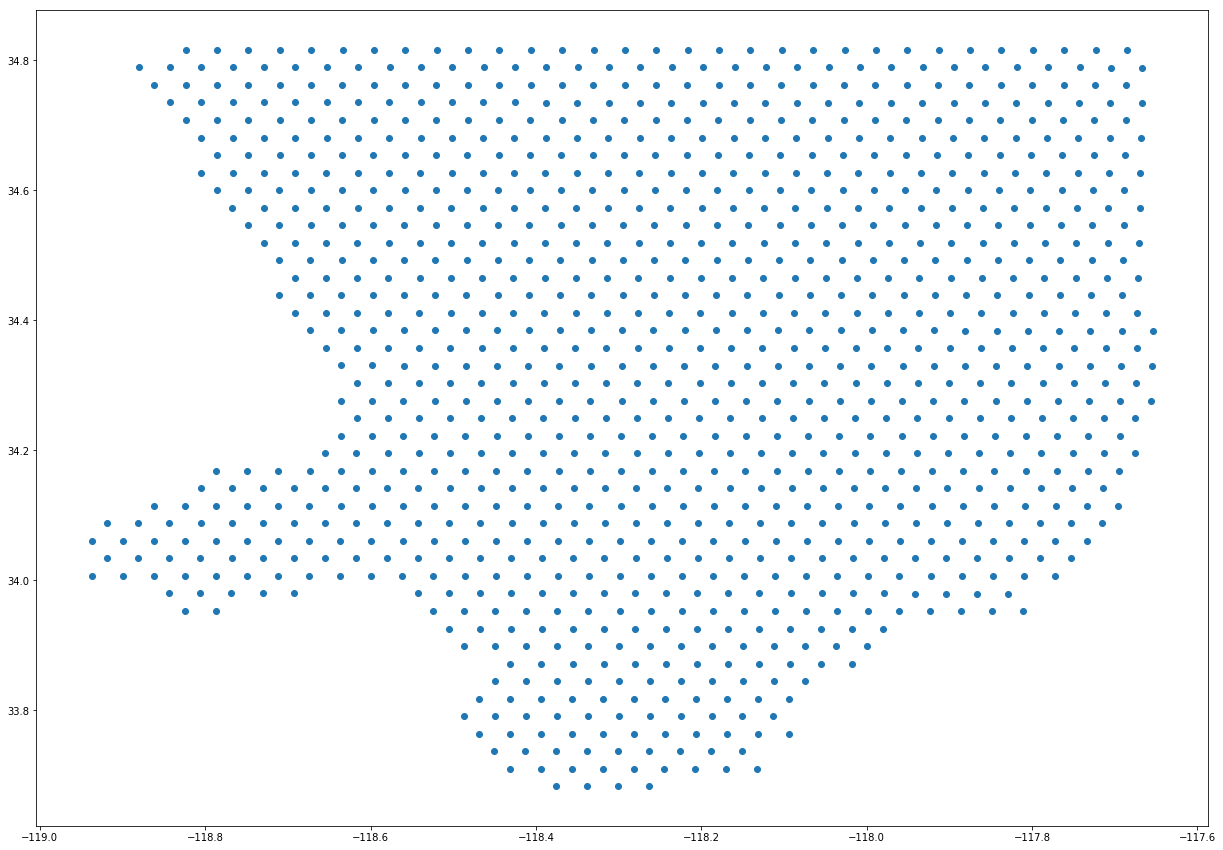

In [336]:
plt.figure(figsize=(21, 15))
lon = [ele[0] for ele in points]
lat = [ele[1] for ele in points]
plt.scatter(x=lon, y=lat)

In [337]:
# https://stackoverflow.com/questions/9427163/

def remove_duplicates(list_of_dictionaries):
    '''
    Removes duplicate dictionaries in the businesses list 
    by matching business ID.
    
    Arguments:
        list_of_dictionaries:       the list containing 
                                    business dictionaries
        
    Returns:
        a modified list without duplicate entries
    '''    
    # a set ignores duplicates
    seen = set()
    new_list = []
    
    for dictionary in list_of_dictionaries:
        # grab the id
        i = dictionary['id']
        
        # if we haven't seen the id yet, add it to the set
        if i not in seen:
            seen.add(i)
            # and then add the dictionary to the new list
            new_list.append(dictionary)
            
    # otherwise, we ignore
    print(f'{len(new_list)} unique listings from {len(list_of_dictionaries)} aggregated results')
    return new_list

In [344]:
def la_county_yelp_scanner(radius, start=0, end=-1, sleep=0.25):
    '''
    Grabs listings from a set of coordinates within LA county.
    
    Arguments:
        radius (float):     search radius, in meters
        start (int):        where to start our loop
        end (float):        where to end our loop
        sleep (float):      induced delay, in seconds
                            (estimated max QPS of five per second)
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
        shotgun()
    '''
    # just because it takes such a long time
    start_time = time.time()
    
    start = int(start)
    end = int(end)
    
    # grab all the points within LA county
    points = get_la_county_points(radius)
    
    if end == -1:
        end = len(points)
    elif end < start:
        end = start + end
    
    businesses = []
    error_tracker = None
    
    '''
    there is a high chance we will reach our max call limit
    with this function. for that reason, we wanted to add an
    option to resume the function using another API key.
    '''
    
    for i in range(start, end):
        point = points[i]
        
        # points are [longitude, latitude]
        b = get_businesses(radius, lon=point[0], lat=point[1], sleep=sleep)
        
        # prints and returns parameters to resume function
        if b == 429:
            error_tracker = {'radius': radius, 'error_info': {}}
            error_tracker['error_info']['marker']    = start + i
            error_tracker['error_info']['latitude']  = point[0]
            error_tracker['error_info']['longitude'] = point[1]
            error_tracker['error_info']['sleep']     = sleep
            
            print(f'''
            ==================================================================
            
            use another API key to re-run the code with the following arguments:
            
            la_county_yelp_scanner({radius}, start={start + i}, end={end}, sleep={sleep})
            
            ==================================================================            
            ''')
            
            return businesses, error_tracker
        
        # adds businesses if things go well
        businesses.extend(b)
    
    # removes duplicate entries from overlapping search queries
    cleaned = remove_duplicates(businesses)
    
    if len(cleaned) == 0:
        print('please consider widening your search parameters.')
    
    else:        
        end_time = time.time()
        elapsed = end_time - start_time

        print(f'elapsed time: {round(elapsed / 60, 1)} min.')
        print(f'overall efficiency: {round(elapsed / len(cleaned) * 1000, 1)} seconds per 1000 listings.')
    
    return businesses, error_tracker

In [346]:
b, e = la_county_yelp_scanner(1000, start=400, end=10, sleep=0.3)

=== sub-search of 24 listings finished!
=== sub-search of 28 listings finished!
=== 100 out of 223
=== 200 out of 223
=== sub-search of 223 listings finished!
=== sub-search of 39 listings finished!
=== sub-search of 28 listings finished!
=== sub-search of 32 listings finished!
=== sub-search of 82 listings finished!
=== sub-search of 30 listings finished!
=== sub-search of 28 listings finished!
=== sub-search of 34 listings finished!
413 unique listings from 414 aggregated results
elapsed time: 0.3 min.
overall efficiency: 41.1 seconds per 1000 listings.


In [308]:
b[:5]

[{'id': '9IoX69UKti9MJOEGMHtQTA',
  'latitude': 33.9253478095797,
  'longitude': -118.242861628532,
  'price': '$',
  'review_count': 3,
  'rating': 3.5,
  'zip_code': '90059',
  'city': 'Los Angeles',
  'alias': 'swendelis-cafe-los-angeles',
  'categories': [{'alias': 'cafes', 'title': 'Cafes'}]},
 {'id': 'u9hCeElKWuXr9W2Fp1n-Zg',
  'latitude': 33.926628,
  'longitude': -118.239003,
  'price': '$',
  'review_count': 22,
  'rating': 2.0,
  'zip_code': '90059',
  'city': 'Los Angeles',
  'alias': 'taco-bell-los-angeles-19',
  'categories': [{'alias': 'mexican', 'title': 'Mexican'},
   {'alias': 'tex-mex', 'title': 'Tex-Mex'},
   {'alias': 'hotdogs', 'title': 'Fast Food'}]},
 {'id': 'rgl2fSFe9ddQkxmEoalBGw',
  'latitude': 33.925355,
  'longitude': -118.238753,
  'price': '$',
  'review_count': 9,
  'rating': 3.0,
  'zip_code': '90059',
  'city': 'Los Angeles',
  'alias': 'subway-restaurants-los-angeles-52',
  'categories': [{'alias': 'sandwiches', 'title': 'Sandwiches'}]},
 {'id': '3ovQL

### function graveyard

In [219]:
def DEFUNCT_get_businesses(lon, lat, radius, force=False):
    '''
    Grabs as many businesses as allowed by the Yelp API given geographic coordinates and search radius.
    
    Arguments:
        lat:            latitude, in decimal degrees
        lon:            longitude, in decimal degrees
        radius:         search radius, in meters
        force:          forces the function to gather results even if over 1000 businesses are returned
        
    Returns:
        a list containing dictionaries of each business listing
    
    Dependencies:
        add_businesses()
    '''    
    radius = int(radius)
    
    businesses = []
    
    params = {
        'limit': 50, 
        'latitude': lat,
        'longitude': lon,
        'radius': radius,
        'offset': 0,
        'sort_by': 'distance'
    }

    response = requests.get(URL, headers=HEADERS, params=params)
    
    total = response.json()['total']
    
    error_coords = []
    
    if (total > 1000):
        print(f'caution: query returns approximately {round(total, -2)} listings.')
        error_coords.append([lon, lat])
        if force == False:
            return None
    
    else:
        add_businesses(response, businesses)
        
        maximum = min(total, 1000)
        
        for offset in range(50, maximum, 50):
            params['offset'] = offset
            response = requests.get(URL, headers=HEADERS, params=params)

            if response.status_code == 500:
                time.sleep(2)
                response = requests.get(URL, headers=HEADERS, params=params)

            add_businesses(response, businesses)

            if offset % 100 == 0:
                print(f'{offset} out of {total}')
                
            time.sleep(.2)
            
        print(f'finished! {maximum} out of {total}')
        return businesses, error_coords